# 📊 **Benchmarking Prompt Engineering Strategies for Political Evasion Detection**

#### **Objective**

This project evaluates the performance of the Llama 3 model on the QEvasion dataset. Our goal is to determine how varying the number of "in-context" examples (shots) influences the model's ability to classify strategic evasion in political discourse.

#### **The Dataset**

We analyze 308 test samples from the QEvasion corpus, focusing on two tasks:

1. **Clarity Detection**: Is the response a clear reply, or a non-reply?

2. **Evasion Strategy**: Identifying specific techniques (e.g., Dodging, Deflection, Ignorance).

#### **Methodology**

We iterate through four distinct prompting strategies, measuring Accuracy and Macro F1 Score at each stage to observe the "learning curve" of the model without fine-tuning weights.

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
from mlx_lm import load, generate
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

# Import data utilities
from src.data import (
    load_qevasion_prepared,
    build_text_column,
    add_label_ids,
    get_annotator_labels,
    CLARITY_LABELS,
    EVASION_LABELS,
)

# Check for MPS (Apple Silicon GPU) availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("M4 GPU (MPS) is available and ready!")
else:
    print("MPS not found, falling back to CPU.")

M4 GPU (MPS) is available and ready!


In [93]:
def compute_metrics_llama_string(df, pred_cl_col, pred_ev_col):
    # --- TASK 1 : CLARITY (String vs String) ---
    y_true_cl = df['clarity_label'].apply(clean_string)
    y_pred_cl = df[pred_cl_col].apply(clean_string)
    
    cl_acc = accuracy_score(y_true_cl, y_pred_cl)
    cl_f1 = f1_score(y_true_cl, y_pred_cl, average='macro')

    # --- TASK 2 : EVASION (String vs Set/List) ---
    mask = df['annotator_labels'].notna()
    eval_df = df[mask].copy()
    
    def check_hit(row):
        pred = clean_string(row[pred_ev_col])
        truth_set = {clean_string(label) for label in row['annotator_labels']}
        return 1 if pred in truth_set else 0

    hits = eval_df.apply(check_hit, axis=1)
    ev_acc = hits.mean() 

    return {
        "clarity_acc": cl_acc, "clarity_f1": cl_f1,
        "evasion_acc": ev_acc, 
    }

def clean_string(s):
    """Normalize string by stripping whitespace and converting to lowercase"""
    if pd.isna(s):
        return ""
    return str(s).strip().lower()

## Load & Explore Data

⚠️ Do not run before other


DATASET DESCRIPTION

Train: 3448 examples
Test:  308 examples (multi-annotator)

Clarity labels: ['Ambivalent', 'Clear Non-Reply', 'Clear Reply']
Evasion labels: ['Claims ignorance', 'Clarification', 'Declining to answer', 'Deflection', 'Dodging', 'Explicit', 'General', 'Implicit', 'Partial/half-answer']


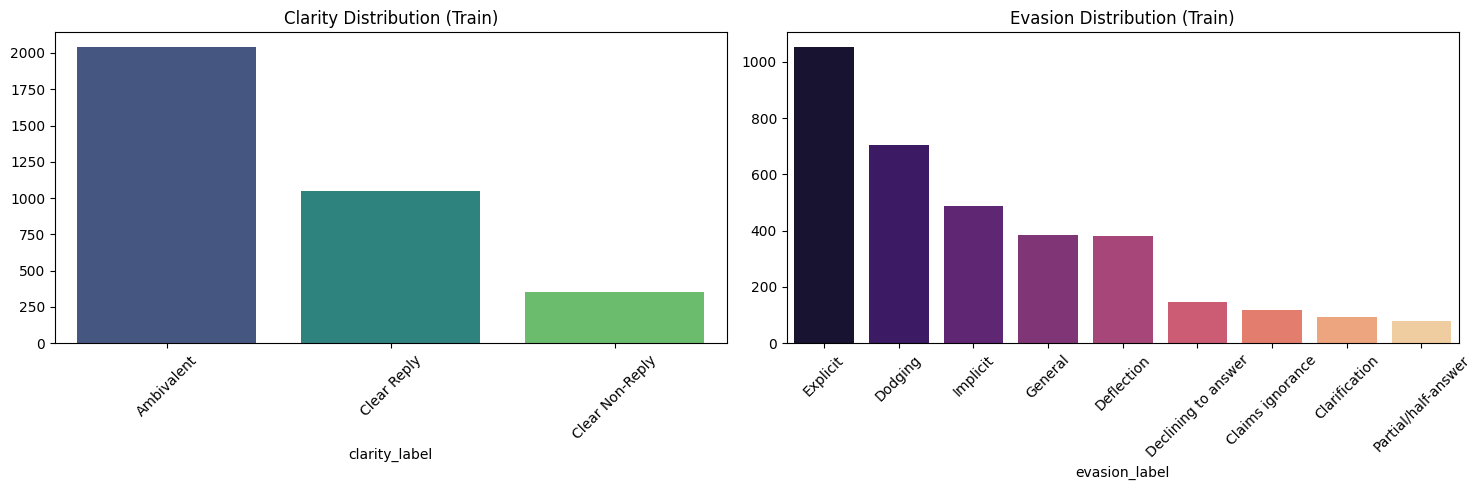


DATASET DESCRIPTION

Train: 3448 examples
Test:  308 examples (multi-annotator)

Clarity labels: ['Ambivalent', 'Clear Non-Reply', 'Clear Reply']
Evasion labels: ['Claims ignorance', 'Clarification', 'Declining to answer', 'Deflection', 'Dodging', 'Explicit', 'General', 'Implicit', 'Partial/half-answer']


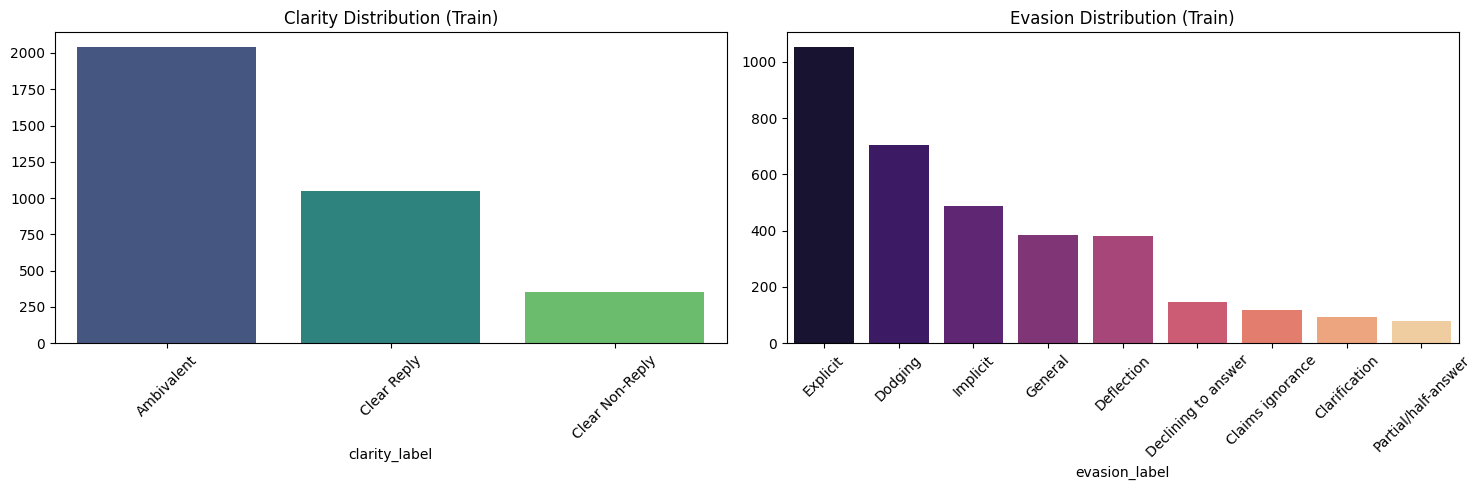

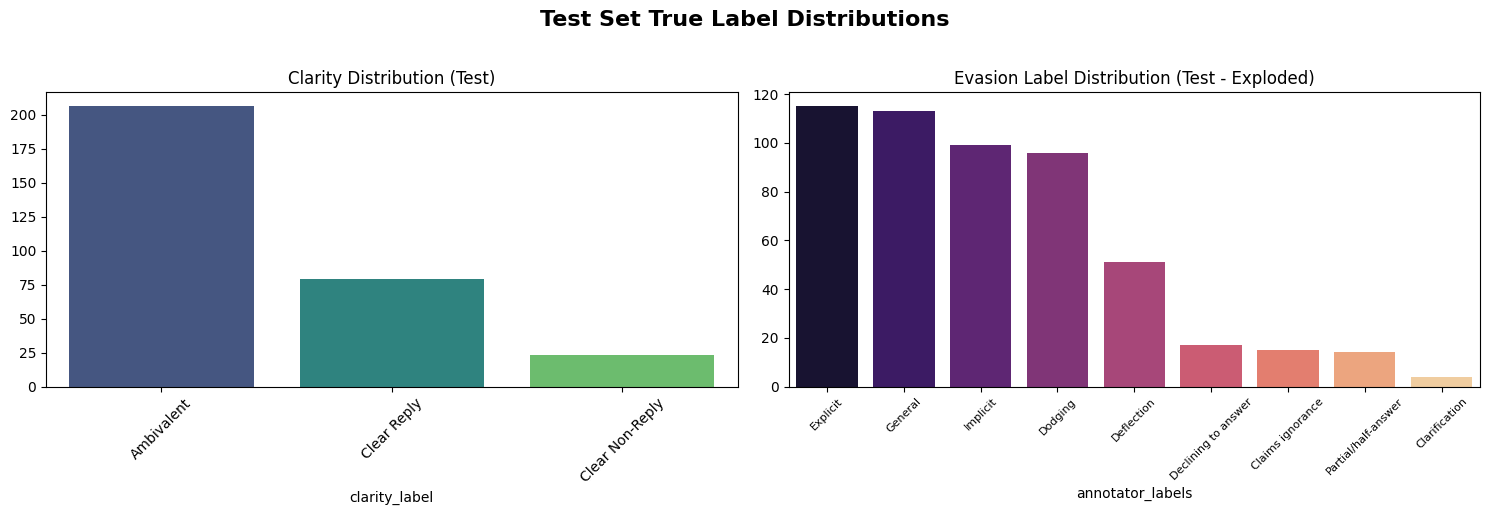

In [ ]:
# Load dataset
dataset = load_qevasion_prepared()

train_df_raw = dataset["train"].to_pandas()
test_df_raw = dataset["test"].to_pandas()

def preprocess_for_llama(df):
    df = build_text_column(df)
    df = add_label_ids(df)      
    return df

train_in = preprocess_for_llama(train_df_raw)
test_in = preprocess_for_llama(test_df_raw)

# Add annotator labels for test set (for Evasion Acc calculation)
test_in["annotator_labels"] = test_in.apply(get_annotator_labels, axis=1)
print("\n" + "="*60)
print("DATASET DESCRIPTION")
print("="*60)

print(f"\nTrain: {len(train_in)} examples")
print(f"Test:  {len(test_in)} examples (multi-annotator)")
print(f"\nClarity labels: {CLARITY_LABELS}")
print(f"Evasion labels: {EVASION_LABELS}")


# --- VISUALISATION TRAIN ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Clarity - Train
cl_train = train_in['clarity_label'].value_counts()
sns.barplot(x=cl_train.index, y=cl_train.values, ax=axes[0], palette='viridis', hue=cl_train.index, legend=False)
axes[0].set_title('Clarity Distribution (Train)')
axes[0].tick_params(axis='x', rotation=45)

# Evasion - Train
ev_train = train_in['evasion_label'].value_counts()
sns.barplot(x=ev_train.index, y=ev_train.values, ax=axes[1], palette='magma', hue=ev_train.index, legend=False)
axes[1].set_title('Evasion Distribution (Train)')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# --- VISUALISATION TEST (Le "Gold Standard") ---
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 5))

# Clarity - Test
cl_test = test_in['clarity_label'].value_counts()
sns.barplot(x=cl_test.index, y=cl_test.values, ax=axes2[0], palette='viridis', hue=cl_test.index, legend=False)
axes2[0].set_title('Clarity Distribution (Test)')
axes2[0].tick_params(axis='x', rotation=45)

# Evasion - Test 
ev_test_series = test_in['annotator_labels'].apply(list).explode()
ev_test_counts = ev_test_series.value_counts()

sns.barplot(x=ev_test_counts.index, y=ev_test_counts.values, ax=axes2[1], palette='magma', hue=ev_test_counts.index, legend=False)
axes2[1].set_title('Evasion Label Distribution (Test - Exploded)')
axes2[1].tick_params(axis='x', rotation=45, labelsize=8)

fig.suptitle('Train Set True Label Distributions', fontsize=16, fontweight='bold', y=1.02)  
fig2.suptitle('Test Set True Label Distributions', fontsize=16, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()


## Load Model

In [22]:
model_name = "mlx-community/Meta-Llama-3.1-8B-Instruct-4bit"
model, tokenizer = load(model_name)

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
test_full = test_in.copy()

## **Section 1: Zero-Shot Classification**

In this section, we test the model's raw 'instinct.' We provide instructions and definitions but no examples. This establishes a performance baseline, showing what the model understands about political discourse from its pre-training alone

### Prompt and Inference

In [60]:
# --- STEP 1: DEFINE THE PROMPT & INFERENCE ---
def analyze_exchange(question, answer):
    # This prompt uses "Chain-of-Thought" to improve accuracy
    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a political analyst. Analyze the provided Question and Answer for strategic evasion.
Respond strictly in JSON format with three keys:
"reasoning": (1 sentence explanation)
"clarity": (Pick one: "Clear Reply", "Ambivalent", "Clear Non-Reply")
"evasion": (Pick one: "Explicit", "Implicit", "General", "Deflection", "Dodging", "Declining", "Ignorance", "Clarification", "Partial")
<|eot_id|><|start_header_id|>user<|end_header_id|>
Question: {question}
Answer: {answer}<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

    response = generate(model, tokenizer, prompt=prompt, max_tokens=400, verbose=False)
    
    try:
        # Extract JSON from potential conversational filler
        res_json = json.loads(response[response.find('{'):response.rfind('}')+1])
        return res_json
    except:
        return {"clarity": "Error", "evasion": "Error"}
    
 # --- STEP 2: RUN INFERENCE WITH PROGRESS BAR ---
results = []

for row in tqdm(test_full.itertuples(index=False), total=len(test_full)):
    res = analyze_exchange(row.interview_question, row.interview_answer)
    results.append(res)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)
test_full['pred_clarity_zeroshot'] = results_df['clarity']
test_full['pred_evasion_zeroshot'] = results_df['evasion']

100%|██████████| 308/308 [42:45<00:00,  8.33s/it]


### Zero Shot Results

In [64]:
# --- STEP 3 : DISPLAY METRICS ---
metrics_zeroshot = compute_metrics_llama_string(test_full, 'pred_clarity_zeroshot', 'pred_evasion_zeroshot')
print("="*60)
print("ZERO-SHOT LLAMA3 METRICS")
print("="*60)
print(f"Clarity Accuracy: {metrics_zeroshot['clarity_acc']:.2%}")
print(f"Clarity F1: {metrics_zeroshot['clarity_f1']:.2%}")
print(f"Evasion Accuracy: {metrics_zeroshot['evasion_acc']:.2%}")

ZERO-SHOT LLAMA3 METRICS
Clarity Accuracy: 33.12%
Clarity F1: 30.57%
Evasion Accuracy: 32.14%


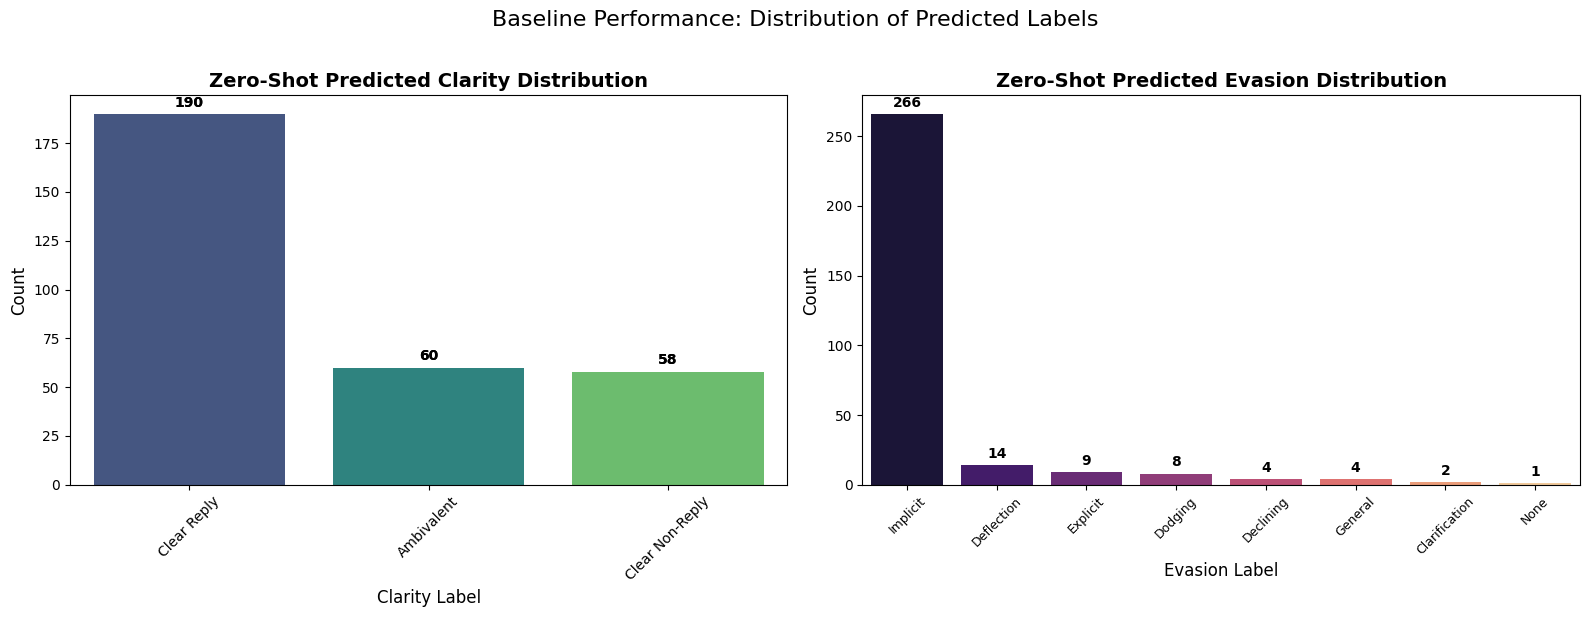

In [ ]:
# --- STEP 4 : VISUALIZE RESULTS ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Predicted Clarity Distribution
clarity_counts = test_full['pred_clarity_zeroshot'].value_counts()
sns.barplot(x=clarity_counts.index, y=clarity_counts.values, ax=axes[0], 
            palette='viridis', hue=clarity_counts.index, legend=False)

# Add numeric labels on top of bars
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontweight='bold')

axes[0].set_title('Zero-Shot Predicted Clarity Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clarity Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# 2. Predicted Evasion Distribution
evasion_counts = test_full['pred_evasion_zeroshot'].value_counts()
sns.barplot(x=evasion_counts.index, y=evasion_counts.values, ax=axes[1], 
            palette='magma', hue=evasion_counts.index, legend=False)

# Add numeric labels on top of bars
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontweight='bold')

axes[1].set_title('Zero-Shot Predicted Evasion Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Evasion Label', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=9)

# Adding a global title to the whole figure
plt.suptitle("Zero Shot Performance: Distribution of Predicted Labels", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

## **Section 2: One-Shot Learning**
One-shot prompting introduces a single representative example (a 'Partial/half-answer'). This is designed to fix formatting issues and provide a single 'anchor' for the model's logic. We expect a significant jump in JSON reliability here.

### Prompt

In [80]:
# --- 1. ONE SHOT PROMPT ---
ONE_SHOT_PROMPT = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert political discourse analyst. Your task is to classify a politician's answer.

### DEFINITIONS:
- CLARITY: [Clear Reply, Ambivalent, Clear Non-Reply]
- EVASION: [Explicit, Implicit, General, Deflection, Dodging, Declining to answer, Claims ignorance, Clarification, Partial/half-answer]

### EXAMPLE:
Question: "Mr. President, what are your thoughts about a second round of direct payments to Americans...?"
Answer: "Well, we're talking about that... I want to see a payroll tax cut. I want to see various things... It's a transition to greatness, and greatness is next year..."
Analysis: {{
  "reasoning": "The speaker acknowledges the topic of direct payments but pivots primarily to discussing payroll taxes and general economic optimism. This makes the reply indirect and incomplete.",
  "clarity": "Ambivalent",
  "evasion": "Partial/half-answer"
}}

### TASK:
Analyze the following exchange and output strictly in JSON.
Question: {question}
Answer: {answer}
Analysis: <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

### Inference

In [81]:
# --- 2. INFERENCE FUNCTION ---
def run_aplus_test(df, model, tokenizer):
    results = []
    
    for row in tqdm(df.itertuples(index=False), total=len(df)):
        # Construct the prompt
        prompt = ONE_SHOT_PROMPT.format(
            question=row.interview_question, 
            answer=row.interview_answer
        )
        
        # We use default generate for consistency on M4
        # Setting max_tokens to 400 to allow for the Reasoning + JSON
        response = generate(model, tokenizer, prompt=prompt, max_tokens=400)
        
        try:
            # Extract JSON from the response
            json_str = response[response.find('{'):response.rfind('}')+1]
            res_json = json.loads(json_str)
            
            # Safety cleanup for label naming inconsistencies
            if "Partial" in res_json.get('evasion', ''):
                res_json['evasion'] = "Partial/half-answer"
            if res_json.get('evasion') == "Declining":
                res_json['evasion'] = "Declining to answer"
            if res_json.get('evasion') == "Ignorance":
                res_json['evasion'] = "Claims ignorance"
                
            results.append(res_json)
        except Exception as e:
            print(f"Error parsing JSON: {e}")
            results.append({"reasoning": "Error", "clarity": "Ambivalent", "evasion": "General"})
            
    return pd.DataFrame(results)

# --- 3. RUN THE TEST ---
preds_df = run_aplus_test(test_full, model, tokenizer)

# Join results to our datset
test_full['pred_clarity_oneshot'] = preds_df['clarity'].values
test_full['pred_evasion_oneshot'] = preds_df['evasion'].values
test_full['pred_reasoning_oneshot'] = preds_df['reasoning'].values

 15%|█▍        | 46/308 [08:33<51:43, 11.85s/it]  

Error parsing JSON: Extra data: line 7 column 1 (char 243)


 32%|███▏      | 100/308 [18:06<37:44, 10.89s/it] 

Error parsing JSON: Extra data: line 7 column 1 (char 228)


 38%|███▊      | 116/308 [21:03<41:22, 12.93s/it]

Error parsing JSON: Extra data: line 6 column 1 (char 252)


 43%|████▎     | 131/308 [23:45<31:02, 10.52s/it]

Error parsing JSON: Extra data: line 7 column 1 (char 228)


 47%|████▋     | 146/308 [26:34<26:47,  9.92s/it]

Error parsing JSON: Expecting ',' delimiter: line 5 column 17 (char 356)


 63%|██████▎   | 194/308 [34:29<17:42,  9.32s/it]

Error parsing JSON: Extra data: line 7 column 1 (char 243)


 65%|██████▍   | 200/308 [35:31<22:02, 12.25s/it]

Error parsing JSON: Extra data: line 6 column 1 (char 252)


 80%|███████▉  | 245/308 [52:24<1:08:30, 65.25s/it] 

Error parsing JSON: Extra data: line 6 column 1 (char 252)


100%|██████████| 308/308 [1:02:39<00:00, 12.21s/it]


### Results

In [94]:
# --- STEP 4 : DISPLAY METRICS ---
metrics_oneshot = compute_metrics_llama_string(test_full, 'pred_clarity_oneshot', 'pred_evasion_oneshot')
print("\n" + "="*60)
print("ONE-SHOT LLAMA3 METRICS")
print("="*60)
print(f"Clarity Accuracy: {metrics_oneshot['clarity_acc']:.2%}")
print(f"Clarity F1: {metrics_oneshot['clarity_f1']:.2%}")
print(f"Evasion Accuracy: {metrics_oneshot['evasion_acc']:.2%}")


ONE-SHOT LLAMA3 METRICS
Clarity Accuracy: 36.04%
Clarity F1: 36.51%
Evasion Accuracy: 24.35%


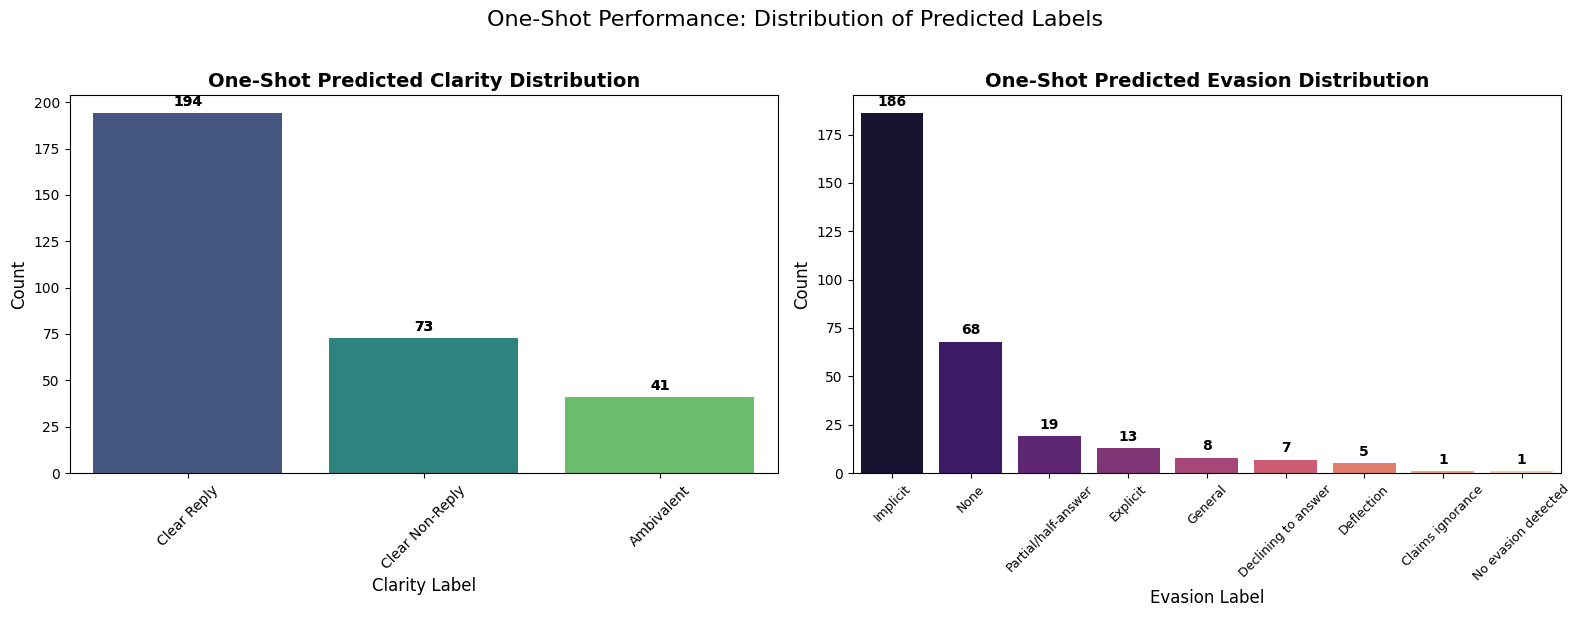

In [96]:
# --- STEP 5 : VISUALIZE RESULTS ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Predicted Clarity Distribution
clarity_counts = test_full['pred_clarity_oneshot'].value_counts()
sns.barplot(x=clarity_counts.index, y=clarity_counts.values, ax=axes[0], 
            palette='viridis', hue=clarity_counts.index, legend=False)

# Add numeric labels on top of bars
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontweight='bold')

axes[0].set_title('One-Shot Predicted Clarity Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clarity Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# 2. Predicted Evasion Distribution
evasion_counts = test_full['pred_evasion_oneshot'].value_counts()
sns.barplot(x=evasion_counts.index, y=evasion_counts.values, ax=axes[1], 
            palette='magma', hue=evasion_counts.index, legend=False)

# Add numeric labels on top of bars
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontweight='bold')

axes[1].set_title('One-Shot Predicted Evasion Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Evasion Label', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=9)

# Adding a global title to the whole figure
plt.suptitle("One-Shot Performance: Distribution of Predicted Labels", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

## **Section 3: 3-Shot Strategy**

We increase the complexity by providing three diverse examples (Clear, Ambivalent, and Non-Reply). This helps the model begin to distinguish the boundaries between Task 1 (Clarity) and Task 2 (Evasion) more effectively

### Prompt

In [97]:
# STEP 1: DEFINE THE FEW-SHOT PROMPT ---
FEW_SHOT_PROMPT_3 = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert political discourse analyst. Your task is to classify a politician's answer based on a provided question.

### DEFINITIONS:
- CLARITY: [Clear Reply, Ambivalent, Clear Non-Reply]
- EVASION TECHNIQUES: [Explicit, Implicit, General, Deflection, Dodging, Declining, Ignorance, Clarification, Partial]

### CONSTRAINTS & RULES:
1. If Clarity is "Clear Reply", the Evasion technique MUST be "Explicit".
2. If Clarity is "Clear Non-Reply" or "Ambivalent", the Evasion technique MUST NOT be "Explicit".
3. The 'evasion' key MUST contain exactly ONE string from the provided list.

### EXAMPLES:
Question: "Will you raise taxes?"
Answer: "We are committed to a balanced budget that serves all Americans."
Analysis: {{"reasoning": "The speaker avoids the specific 'yes/no' on taxes by pivoting to a general positive goal.", "clarity": "Ambivalent", "evasion": "General"}}

Question: "Did you meet with the lobbyist on Tuesday?"
Answer: "I have meetings with many people throughout the week."
Analysis: {{"reasoning": "The speaker uses a general statement to avoid confirming a specific event.", "clarity": "Clear Non-Reply", "evasion": "Dodging"}}

Question: "How much will this plan cost?"
Answer: "The cost is exactly 50 million dollars over four years."
Analysis: {{"reasoning": "The speaker provides the specific numerical information requested.", "clarity": "Clear Reply", "evasion": "Explicit"}}

### TASK:
Analyze the following exchange and output strictly in JSON format.
Question: {question}
Answer: {answer}
Analysis: <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

### Inference

In [98]:
# --- 2. INFERENCE FUNCTION ---
def run_aplus_test(df, model, tokenizer):
    results = []
    
    for row in tqdm(df.itertuples(index=False), total=len(df)):
        # Construct the prompt
        prompt = FEW_SHOT_PROMPT_3.format(
            question=row.interview_question, 
            answer=row.interview_answer
        )
        
        # We use default generate for consistency on M4
        # Setting max_tokens to 400 to allow for the Reasoning + JSON
        response = generate(model, tokenizer, prompt=prompt, max_tokens=400)
        
        try:
            # Extract JSON from the response
            json_str = response[response.find('{'):response.rfind('}')+1]
            res_json = json.loads(json_str)
            
            # Safety cleanup for label naming inconsistencies
            if "Partial" in res_json.get('evasion', ''):
                res_json['evasion'] = "Partial/half-answer"
            if res_json.get('evasion') == "Declining":
                res_json['evasion'] = "Declining to answer"
            if res_json.get('evasion') == "Ignorance":
                res_json['evasion'] = "Claims ignorance"
                
            results.append(res_json)
        except Exception as e:
            print(f"Error parsing JSON: {e}")
            results.append({"reasoning": "Error", "clarity": "Ambivalent", "evasion": "General"})
            
    return pd.DataFrame(results)

# --- 3. RUN THE TEST ---
preds_df = run_aplus_test(test_full, model, tokenizer)

# Join results to our dataset
test_full['pred_clarity_3shot'] = preds_df['clarity'].values
test_full['pred_evasion_3shot'] = preds_df['evasion'].values
test_full['pred_reasoning_3shot'] = preds_df['reasoning'].values

100%|██████████| 308/308 [1:38:58<00:00, 19.28s/it]   


### Results

In [99]:
# --- STEP 4 : DISPLAY METRICS ---
metrics_3shot = compute_metrics_llama_string(test_full, 'pred_clarity_3shot', 'pred_evasion_3shot')
print("="*60)
print("3-SHOT LLAMA3 METRICS")
print("="*60)
print(f"Clarity Accuracy: {metrics_3shot['clarity_acc']:.2%}")
print(f"Clarity F1: {metrics_3shot['clarity_f1']:.2%}")
print(f"Evasion Accuracy: {metrics_3shot['evasion_acc']:.2%}")

3-SHOT LLAMA3 METRICS
Clarity Accuracy: 22.73%
Clarity F1: 24.88%
Evasion Accuracy: 41.56%


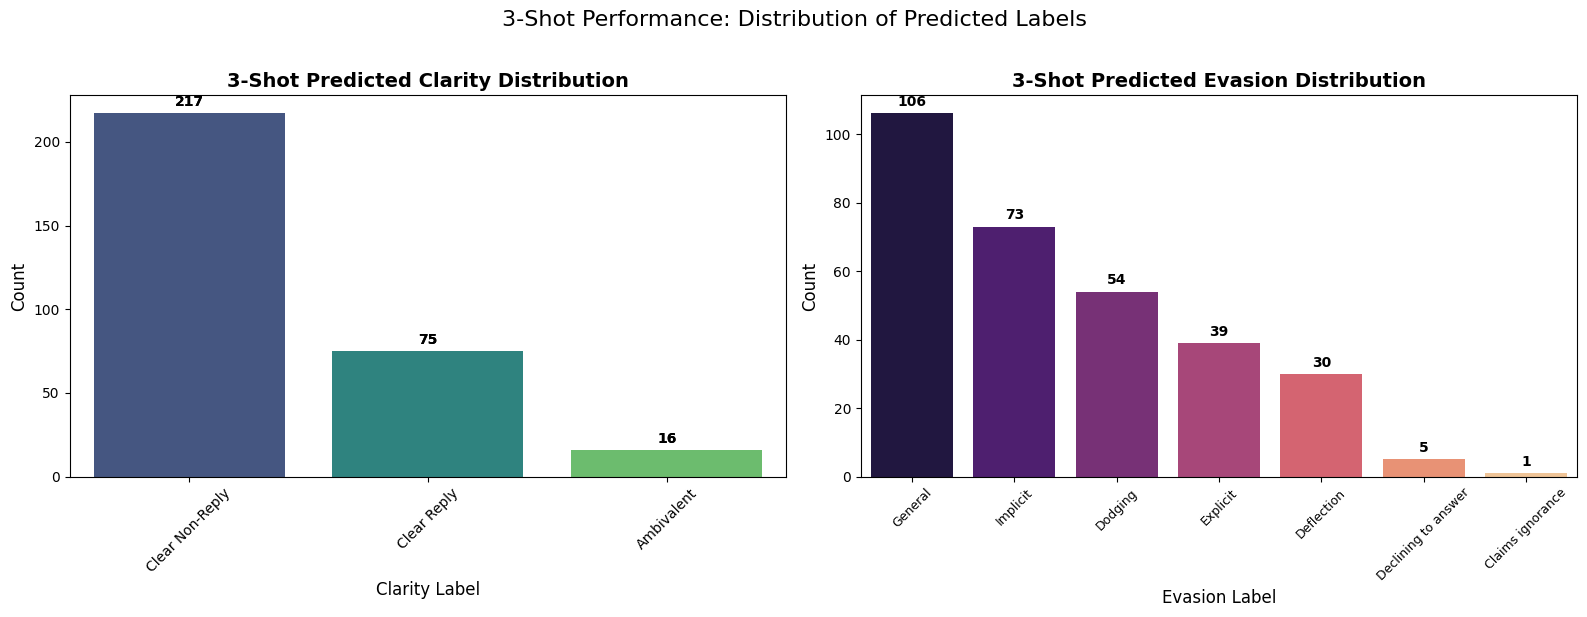

In [100]:
# --- STEP 5 : VISUALIZE RESULTS ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Predicted Clarity Distribution
clarity_counts = test_full['pred_clarity_3shot'].value_counts()
sns.barplot(x=clarity_counts.index, y=clarity_counts.values, ax=axes[0], 
            palette='viridis', hue=clarity_counts.index, legend=False)

# Add numeric labels on top of bars
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontweight='bold')

axes[0].set_title('3-Shot Predicted Clarity Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clarity Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# 2. Predicted Evasion Distribution
evasion_counts = test_full['pred_evasion_3shot'].value_counts()
sns.barplot(x=evasion_counts.index, y=evasion_counts.values, ax=axes[1], 
            palette='magma', hue=evasion_counts.index, legend=False)

# Add numeric labels on top of bars
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontweight='bold')

axes[1].set_title('3-Shot Predicted Evasion Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Evasion Label', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=9)

# Adding a global title to the whole figure
plt.suptitle("3-Shot Performance: Distribution of Predicted Labels", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

## **Section 4: 9-Shot Strategy**

The full 9-shot prompt provides one exemplar for every evasion category. This provides the model with the maximum possible context for the subtle differences between techniques like 'Dodging' and 'Deflection'.

### Extract one example for each class

In [101]:
# The 9 evasion categories in the QEvasion dataset
evasion_classes = [
    "Explicit", "Implicit", "General", "Deflection", 
    "Dodging", "Declining to answer", "Claims ignorance", 
    "Clarification", "Partial/half-answer"
]

def get_few_shot_data(df):
    examples = {}
    # Drop rows that don't have labels or text
    clean_df = df.dropna(subset=['interview_question', 'interview_answer', 'evasion_label'])
    
    for cls in evasion_classes:
        # Filter for the specific evasion class
        subset = clean_df[clean_df['evasion_label'] == cls]
        
        if not subset.empty:
            # Sample one random example
            sample = subset.sample(1, random_state=42)
            examples[cls] = {
                "question": sample['interview_question'].values[0],
                "answer": sample['interview_answer'].values[0],
                "clarity": sample['clarity_label'].values[0],
                "evasion": cls
            }
        else:
            print(f"Note: Could not find class '{cls}' in evasion_label.")
            
    return examples

# Generate the raw dictionary
train_examples = get_few_shot_data(train_full)

# Print for review
for cls, data in train_examples.items():
    print(f"### {cls} ###")
    print(f"Q: {data['question']}")
    print(f"A: {data['answer']}\n")

### Explicit ###
Q: Q. Thank you very much. We are the real Wall Street Journal.Mr. President, you tweeted earlier asking Virginia and New Jersey residents to vote. Democrat Terry McAuliffe is struggling in a State that you won by 10 points. Do you see—do you see his problems as a rebuke of your Presidency? And could this signal your real losses for Democrats in the midterms?
A: We're going to win. I think we're going to win in Virginia.And you know—you're reporting it being close—the race is very close. It's about who shows up, who turns out.And granted, I did win by a large margin, but the point of the matter is that I think that this is—this is going to be what we all knew from the beginning: This is going to be a tight race. And it is tight. And it's going to get down to turnout, and it's going to—my guess is that I'm going to be landing at 1 o'clock in the morning, East Coast time. That's probably about the time we'll be hearing what the final results are. I think we're going to w

### Prompt

In [116]:
# --- STEP 1: DEFINE FEW-SHOT PROMPT FOR FUTURE USE ---
FEW_SHOT_PROMPT_9 = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert political discourse analyst. Your task is to classify a politician's answer based on a provided question.

### DEFINITIONS:
- CLARITY: [Clear Reply, Ambivalent, Clear Non-Reply]
- EVASION TECHNIQUES: [Explicit, Implicit, General, Deflection, Dodging, Declining, Ignorance, Clarification, Partial]

### CONSTRAINTS & RULES:
1. If Clarity is "Clear Reply", the Evasion technique MUST be "Explicit".
2. If Clarity is "Clear Non-Reply" or "Ambivalent", the Evasion technique MUST NOT be "Explicit".

### EXAMPLES:

### Example: Deflection
Question: "How about will my Korean friends allow me to ask a question on your behalf? Yes or no?"
Answer: "Well, it depends on whether there's a Korean reporter who would rather have the question. No, no takers?"
Analysis: {{
  "reasoning": "Instead of answering 'Yes or no' to the question about Korean friends, the speaker pivots to the presence of Korean reporters. This 'agenda shift' moves the focus away from the personal question to a procedural one about the room's composition.",
  "clarity": "Clear Non-Reply",
  "evasion": "Deflection"
}}

### Example: Dodging
Question: "I wonder if you would share some thoughts on that [bin Laden] anniversary... anybody would have made that call, even Jimmy Carter. So I'm curious to see what you would say about that."
Answer: "First of all... I hardly think that you've seen any excessive celebration... it's a mark of the excellence of our intelligence teams... As far as my personal role and what other folks would do, I'd just recommend that everybody take a look at people's previous statements..."
Analysis: {{
  "reasoning": "The speaker acknowledges the anniversary of bin Laden's killing but ignores the second half of the question regarding his opponent's comments. By selecting only part of the prompt to address while ignoring the adversarial 'Jimmy Carter' comparison, the speaker is dodging.",
  "clarity": "Clear Non-Reply",
  "evasion": "Dodging"
}}

### Example: Declining to answer
Question: "Specifically, have you seen any success in your diplomatic strategy so far? And do you still believe that direct talks are a waste of time?"
Answer: "Well, I think you know me well enough to know that I don't like talking about whether I see success or not in a case such as this. We like to play our cards a little bit close to the vest."
Analysis: {{
  "reasoning": "The speaker explicitly states, 'I don't like talking about whether I see success or not,' and justifies this refusal by claiming a need to 'play cards close to the vest.' This is a clear, overt refusal to provide the requested information.",
  "clarity": "Clear Non-Reply",
  "evasion": "Declining to answer"
}}

### Example: Claims ignorance
Question: "So why don't you go?"
Answer: "I don't know. I'd sort of love—sit right in the front row and stare in their corrupt faces."
Analysis: {{
  "reasoning": "The speaker responds to 'Why don't you go?' with a direct 'I don't know.' By professing a lack of knowledge or a reason for their behavior, they effectively end the inquiry through claimed ignorance.",
  "clarity": "Clear Non-Reply",
  "evasion": "Claims ignorance"
}}

### Example: Clarification
Question: "Do you now see Kim Jong Un as an equal?"
Answer: "In what way?"
Analysis: {{
  "reasoning": "The speaker does not provide an answer but instead responds with a counter-question ('In what way?') to seek further information. This is a strategy to clarify the premise before committing to a stance.",
  "clarity": "Clear Non-Reply",
  "evasion": "Clarification"
}}

### Example: Partial/half-answer
Question: "Mr. President, what are your thoughts about a second round of direct payments to Americans...?"
Answer: "Well, we're talking about that... I want to see a payroll tax cut. I want to see various things... It's a transition to greatness, and greatness is next year..."
Analysis: {{
  "reasoning": "The speaker addresses the topic of direct payments but spends the majority of the response talking about payroll tax cuts and 'transition to greatness.' Because they only partially answer the 'direct payments' query while shifting the focus to unrelated economic goals, it is a half-answer.",
  "clarity": "Ambivalent",
  "evasion": "Partial/half-answer"
}}

### Example: General
Question: "Can I ask just one follow-up?"
Answer: "Maybe."
Analysis: {{
  "reasoning": "The speaker responds to a specific request for a follow-up question with a broad, non-committal 'Maybe.' This provides a general sentiment without a specific commitment, typical of an indirect and incomplete reply.",
  "clarity": "Ambivalent",
  "evasion": "General"
}}

### Example: Implicit
Question: "Was it pretty far from the White House? Or was it right in front of that?"
Answer: "I can only tell you, they're going to give you a briefing. It was outside of the premises, near the fence, but outside of the premises."
Analysis: {{
  "reasoning": "The speaker answers the specific location question ('Was it far or in front?') by stating it was 'outside the premises, near the fence.' While the answer is provided, it relies on a briefing for full context, making the reply technically present but indirect.",
  "clarity": "Ambivalent",
  "evasion": "Implicit"
}}

### Example: Explicit
Question: "Mr. President... Democrat Terry McAuliffe is struggling... Do you see—do you see his problems as a rebuke of your Presidency?"
Answer: "We're going to win... I don't believe—and I've not seen any evidence that whether or not I am doing well or poorly... is going to have any real impact on winning or losing."
Analysis: {{
  "reasoning": "The President directly addresses the core question about whether election results are a rebuke of his presidency by stating he sees no evidence that his agenda's progress impacts winning or losing. Because the answer provides a direct, identifiable stance, it is a Clear Reply.",
  "clarity": "Clear Reply",
  "evasion": "Explicit"
}}


### TASK:
Analyze the following exchange and output strictly in JSON format.
Question: {question}
Answer: {answer}
Analysis: <|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

### Inference

In [ ]:
# --- 2. INFERENCE FUNCTION ---
def run_aplus_test(df, model, tokenizer):
    results = []
    
    for row in tqdm(df.itertuples(index=False), total=len(df)):
        # Construct the prompt
        prompt = FEW_SHOT_PROMPT_9.format(
            question=row.interview_question, 
            answer=row.interview_answer
        )
        
        # We use default generate for consistency on M4
        # Setting max_tokens to 400 to allow for the Reasoning + JSON
        response = generate(model, tokenizer, prompt=prompt, max_tokens=400)
        
        try:
            # Extract JSON from the response
            json_str = response[response.find('{'):response.rfind('}')+1]
            res_json = json.loads(json_str)
            
            # Safety cleanup for label naming inconsistencies
            if "Partial" in res_json.get('evasion', ''):
                res_json['evasion'] = "Partial/half-answer"
            if res_json.get('evasion') == "Declining":
                res_json['evasion'] = "Declining to answer"
            if res_json.get('evasion') == "Ignorance":
                res_json['evasion'] = "Claims ignorance"
                
            results.append(res_json)
        except Exception as e:
            print(f"Error parsing JSON: {e}")
            results.append({"reasoning": "Error", "clarity": "Ambivalent", "evasion": "General"})
            
    return pd.DataFrame(results)

# --- 3. RUN THE TEST ---
preds_df = run_aplus_test(test_full, model, tokenizer)

# Join results to our dataset
test_full['pred_clarity_9shot'] = preds_df['clarity'].values
test_full['pred_evasion_9shot'] = preds_df['evasion'].values
test_full['pred_reasoning_9shot'] = preds_df['reasoning'].values

 41%|████      | 125/308 [39:25<1:05:33, 21.50s/it]

Error parsing JSON: Extra data: line 7 column 1 (char 422)


 71%|███████   | 219/308 [1:13:49<34:29, 23.26s/it]

### Results

In [104]:
# --- STEP 4 : DISPLAY METRICS ---
metrics_9shot = compute_metrics_llama_string(test_full, 'pred_clarity_9shot', 'pred_evasion_9shot')
print("="*60)
print("9-SHOT LLAMA3 METRICS")
print("="*60)
print(f"Clarity Accuracy: {metrics_9shot['clarity_acc']:.2%}")
print(f"Clarity F1: {metrics_9shot['clarity_f1']:.2%}")
print(f"Evasion Accuracy: {metrics_9shot['evasion_acc']:.2%}")

9-SHOT LLAMA3 METRICS
Clarity Accuracy: 29.55%
Clarity F1: 28.93%
Evasion Accuracy: 38.96%


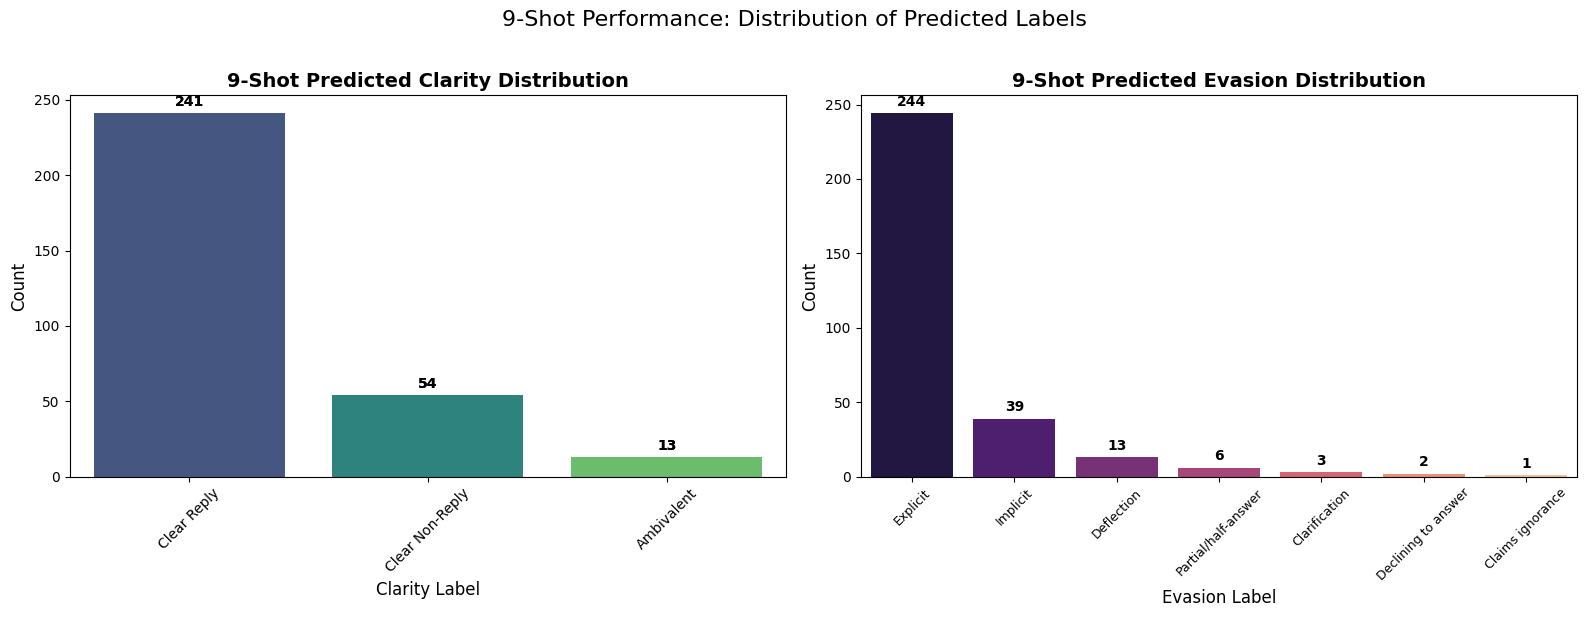

In [105]:
# --- STEP 5 : VISUALIZE RESULTS ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Predicted Clarity Distribution
clarity_counts = test_full['pred_clarity_9shot'].value_counts()
sns.barplot(x=clarity_counts.index, y=clarity_counts.values, ax=axes[0], 
            palette='viridis', hue=clarity_counts.index, legend=False)

# Add numeric labels on top of bars
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontweight='bold')

axes[0].set_title('9-Shot Predicted Clarity Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Clarity Label', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# 2. Predicted Evasion Distribution
evasion_counts = test_full['pred_evasion_9shot'].value_counts()
sns.barplot(x=evasion_counts.index, y=evasion_counts.values, ax=axes[1], 
            palette='magma', hue=evasion_counts.index, legend=False)

# Add numeric labels on top of bars
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, padding=3, fontweight='bold')

axes[1].set_title('9-Shot Predicted Evasion Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Evasion Label', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].tick_params(axis='x', rotation=45, labelsize=9)

# Adding a global title to the whole figure
plt.suptitle("9-Shot Performance: Distribution of Predicted Labels", fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

# To infity and beyond  🌙

In [28]:
def audit_test_set_annotators(df):
    print("=== TEST SET LOGIC AUDIT (MULTI-ANNOTATOR) ===")
    
    # We check each of the 3 annotators
    for i in range(1, 4):
        ann_col = f'annotator{i}'
        
        # Rule: If Annotator says 'Explicit', is Clarity 'Clear Reply'?
        # In the test set, clarity_label is often a single consensus or majority label.
        # We compare the annotator's Task 2 choice against the Task 1 ground truth.
        inconsistent = df[
            (df[ann_col] == 'Explicit') & 
            (df['clarity_label'] != 'Clear Reply')
        ]
        
        count = len(inconsistent)
        total = len(df)
        
        if count > 0:
            print(f"⚠️ Annotator {i}: {count} rows ({count/total:.1%}) label evasion as 'Explicit' for a non-clear reply.")
            # Show one example of what this looks like
            if not inconsistent.empty:
                example = inconsistent.iloc[0]
                print(f"   e.g., Q: {example['interview_question'][:50]}...")
                print(f"   Clarity: {example['clarity_label']} | Annotator {i} Evasion: {example[ann_col]}\n")
        else:
            print(f"✅ Annotator {i}: Perfect logical consistency.\n")

# Run the audit on your test set
audit_test_set_annotators(test_full)

=== TEST SET LOGIC AUDIT (MULTI-ANNOTATOR) ===
⚠️ Annotator 1: 30 rows (9.7%) label evasion as 'Explicit' for a non-clear reply.
   e.g., Q: Q. Harsh. Mr. President, Japan has dropped the thr...
   Clarity: Ambivalent | Annotator 1 Evasion: Explicit

⚠️ Annotator 2: 2 rows (0.6%) label evasion as 'Explicit' for a non-clear reply.
   e.g., Q: Q. Thank you, Mr. President. The world leaders her...
   Clarity: Ambivalent | Annotator 2 Evasion: Explicit

⚠️ Annotator 3: 4 rows (1.3%) label evasion as 'Explicit' for a non-clear reply.
   e.g., Q: Q. Morning, sir. I'd like to ask you another quest...
   Clarity: Ambivalent | Annotator 3 Evasion: Explicit



In [106]:
csv_output_path = "qevasion_llama3_results.csv"
test_full.to_csv(csv_output_path, index=False)
print(f"Results saved to {csv_output_path}")

Results saved to qevasion_llama3_results.csv


In [ ]:
table_results = pd.read_csv(csv_output_path)
print("\n" + "="*60)
print("SAVED RESULTS PREVIEW")
print("="*60)
table_results.head()


SAVED RESULTS PREVIEW


,title,date,president,url,question_order,interview_question,interview_answer,gpt3.5_summary,gpt3.5_prediction,question,...,pred_evasion_zeroshot,pred_clarity_oneshot,pred_evasion_oneshot,pred_reasoning_oneshot,pred_clarity_3shot,pred_evasion_3shot,pred_reasoning_3shot,pred_clarity_9shot,pred_evasion_9shot,pred_reasoning_9shot
0,NaN,NaN,NaN,https://www.presidency.ucsb.edu/documents/the-...,5,"Q. What about the redline, sir?","Well, the world has made it clear that these t...",NaN,NaN,Inquiring about the status or information reg...,...,Implicit,Clear Reply,Implicit,The speaker shifts the focus from the specific...,Clear Non-Reply,General,The speaker avoids directly addressing the 're...,Clear Non-Reply,Implicit,The speaker addresses the question about the r...
1,NaN,NaN,NaN,https://www.presidency.ucsb.edu/documents/the-...,2,Q. Will you invite them to the White House to ...,I think that anytime and anyplace that they ar...,NaN,NaN,Will you invite them to the White House to neg...,...,Implicit,Ambivalent,Implicit,The speaker acknowledges the invitation to the...,Clear Non-Reply,General,The speaker avoids a direct yes or no by empha...,Ambivalent,Partial/half-answer,The politician's answer is a mix of direct and...
2,NaN,NaN,NaN,https://www.presidency.ucsb.edu/documents/the-...,1,"Q. Harsh. Mr. President, Japan has dropped the...",I think that the purpose of the U.N. Security ...,NaN,NaN,Why was it necessary for Japan to drop the thr...,...,Implicit,Clear Reply,NaN,The speaker acknowledges the necessity of Japa...,Clear Reply,Implicit,The speaker uses a combination of diplomatic l...,Clear Reply,Explicit,The President addresses the question about Jap...
3,NaN,NaN,NaN,https://www.presidency.ucsb.edu/documents/the-...,2,Q. The Lebanese Prime Minister is demanding a ...,I'll let Condi talk about the details of what ...,NaN,NaN,When will we see this resolution?,...,Implicit,Ambivalent,Partial/half-answer,The speaker acknowledges the question but shif...,Clear Non-Reply,General,The speaker avoids providing a specific timeli...,Ambivalent,Implicit,The speaker addresses the core question about ...
4,NaN,NaN,NaN,https://www.presidency.ucsb.edu/documents/the-...,7,"Q. Thank you, Mr. President. Back on Iraq, a g...","No, I don't consider it a credible report; nei...",NaN,NaN,Updating the figure of Iraqi deaths,...,Implicit,Clear Reply,Implicit,The speaker acknowledges the discrepancy in de...,Clear Non-Reply,Implicit,The speaker dismisses the report's credibility...,Clear Reply,Explicit,The President addresses the question about the...


In [114]:
table_results[['interview_question', 'interview_answer', 
               'clarity_label', 'evasion_label',
               'pred_clarity_zeroshot', 'pred_evasion_zeroshot',
               'pred_clarity_oneshot', 'pred_evasion_oneshot',
               'pred_clarity_3shot', 'pred_evasion_3shot',
               'pred_clarity_9shot', 'pred_evasion_9shot']].head(10)

,interview_question,interview_answer,clarity_label,evasion_label,pred_clarity_zeroshot,pred_evasion_zeroshot,pred_clarity_oneshot,pred_evasion_oneshot,pred_clarity_3shot,pred_evasion_3shot,pred_clarity_9shot,pred_evasion_9shot
0,"Q. What about the redline, sir?","Well, the world has made it clear that these t...",Ambivalent,NaN,Clear Reply,Implicit,Clear Reply,Implicit,Clear Non-Reply,General,Clear Non-Reply,Implicit
1,Q. Will you invite them to the White House to ...,I think that anytime and anyplace that they ar...,Ambivalent,NaN,Ambivalent,Implicit,Ambivalent,Implicit,Clear Non-Reply,General,Ambivalent,Partial/half-answer
2,"Q. Harsh. Mr. President, Japan has dropped the...",I think that the purpose of the U.N. Security ...,Ambivalent,NaN,Clear Reply,Implicit,Clear Reply,NaN,Clear Reply,Implicit,Clear Reply,Explicit
3,Q. The Lebanese Prime Minister is demanding a ...,I'll let Condi talk about the details of what ...,Ambivalent,NaN,Ambivalent,Implicit,Ambivalent,Partial/half-answer,Clear Non-Reply,General,Ambivalent,Implicit
4,"Q. Thank you, Mr. President. Back on Iraq, a g...","No, I don't consider it a credible report; nei...",Ambivalent,NaN,Clear Reply,Implicit,Clear Reply,Implicit,Clear Non-Reply,Implicit,Clear Reply,Explicit
5,"Q. Thank you, Mr. President. I'd also like to ...",I wouldn't have exactly put it that way. But I...,Ambivalent,NaN,Clear Reply,Implicit,Clear Reply,Implicit,Clear Non-Reply,Dodging,Clear Reply,Explicit
6,Q. Do you feel in some way that there is some ...,"[] Jim, I understand how hard it is, and I als...",Ambivalent,NaN,Clear Reply,Implicit,Clear Reply,Implicit,Clear Non-Reply,General,Clear Non-Reply,Implicit
7,"Q. Lebanon's Parliament Speaker, Nabih Berri, ...","Whatever happens in the U.N., we must not crea...",Ambivalent,NaN,Clear Reply,Implicit,Ambivalent,Partial/half-answer,Clear Non-Reply,General,Clear Non-Reply,Implicit
8,Q. Secretary Rice said that failure is not an ...,"Right. Well, that's why Condi is making the tr...",Ambivalent,NaN,Clear Reply,Implicit,Clear Reply,NaN,Clear Non-Reply,Dodging,Clear Reply,Explicit
9,"Q. Thank you, Mr. President. Iran has indicate...",The final history in the region has yet to be ...,Ambivalent,NaN,Clear Reply,Implicit,Clear Non-Reply,Implicit,Clear Non-Reply,General,Clear Reply,Explicit


In [112]:
# Create a list of dictionaries, each representing a row
all_metrics = [
    {"Strategy": "Zero-Shot", **metrics_zeroshot},
    {"Strategy": "One-Shot", **metrics_oneshot},
    {"Strategy": "3-Shot", **metrics_3shot},
    {"Strategy": "9-Shot", **metrics_9shot}
]

# Build the DataFrame
metrics_df = pd.DataFrame(all_metrics).set_index("Strategy")

print("\n" + "="*60)
print("FINAL BENCHMARK SUMMARY")
print("="*60)
print(metrics_df.T) # Transposed for better vertical reading


FINAL BENCHMARK SUMMARY
Strategy     Zero-Shot  One-Shot    3-Shot    9-Shot
clarity_acc   0.331169  0.360390  0.227273  0.295455
clarity_f1    0.305703  0.365091  0.248788  0.289315
evasion_acc   0.321429  0.243506  0.415584  0.389610


In [ ]:
# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Clarity Accuracy vs F1
comparison_df.plot(x="Strategy", y=["Clarity Acc", "Clarity F1"], 
                   kind="bar", ax=axes[0], color=['#482677', '#238a8d'], alpha=0.8)
axes[0].set_title("Task 1: Clarity Performance Growth", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Score (0.0 - 1.0)")
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f', padding=3)

# Plot 2: Evasion Accuracy
# (Note: Using a line plot here often looks better for 'scaling' trends)
sns.lineplot(data=comparison_df, x="Strategy", y="Evasion Acc", 
             marker="o", markersize=10, linewidth=3, color='#cc4678', ax=axes[1])
axes[1].set_title("Task 2: Evasion Accuracy Trend", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Accuracy")
axes[1].set_ylim(0, 1)
axes[1].grid(linestyle='--', alpha=0.7)

# Final formatting
plt.suptitle("Comparative Evaluation: Shot-Scaling Impact", fontsize=18, y=1.05)
plt.tight_layout()
plt.show()